In [1]:
import sys
sys.path.append('../src')  # Add the src directory

from utils.file_handler import BetfairFileHandler
from models import GRUModel, LSTMModel, TransformerModel, BiLSTMModel, train_model, plot_loss_curves, prepare_dataloaders
from models.model_utils import save_model, load_model, process_multiple_markets, normalize_data
from preprocessing.feature_engineering import calculate_macd, calculate_roc, calculate_moving_average
from preprocessing.data_preprocessor import preprocess_market_data, drop_na_rows, remove_outliers
from models.evaluation import plot_predictions, plot_residuals, plot_residual_histogram
from strategy.base_strategy import BaseFlatBetting
from strategy.simulation import run_sim_process

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import betfairutil
import seaborn as sns
import os
from torch.optim.lr_scheduler import OneCycleLR

/Users/charaka/opt/anaconda3/envs/digital_finance/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
ROOT_DIR = "/Users/charaka/Desktop/Projects/football-lstm-betting"

In [3]:
input_directory = os.path.join(ROOT_DIR, "data/raw/2023/Jan")
output_directory = os.path.join(ROOT_DIR, "data/processed/")

# handler = BetfairFileHandler()
# handler.extract_files(input_directory, output_directory, should_restrict_to_inplay=True, _format=betfairutil.DataFrameFormatEnum.LAST_PRICE_TRADED)

In [4]:
input_directory, output_directory

('/Users/charaka/Desktop/Projects/football-lstm-betting/data/raw/2023/Jan',
 '/Users/charaka/Desktop/Projects/football-lstm-betting/data/processed/')

In [5]:
"/Users/charaka/Desktop/Projects/football-lstm-betting/data/raw/2023/Jan/1/31954039"

'/Users/charaka/Desktop/Projects/football-lstm-betting/data/raw/2023/Jan/1/31954039'

In [6]:
data_folder = "/Users/charaka/Desktop/Projects/football-lstm-betting/data/raw/2023/Jan/1/31954039"
data_files = os.listdir(data_folder,)
data = [f'{data_folder}/{path}' for path in data_files]


In [7]:
data = ['/Users/charaka/Desktop/Projects/football-lstm-betting/data/raw/2023/Jan/1/31954039/1.207325009']

In [8]:
from utils.stratergy_logging_control import BacktestLoggingControl
from strategy.base_strategy import BaseFlatBetting
from flumine import FlumineSimulation, BaseStrategy, utils, clients

In [10]:
strategy = BaseFlatBetting(
    market_filter={
        "markets": data,  
        'market_types':['MATCH_ODDS'],
        "listener_kwargs": {"inplay": False, "seconds_to_start": 80},  
        },
    max_order_exposure=1000,
    max_selection_exposure=1000,
    max_trade_count=1000,
)

client = clients.SimulatedClient()
framework = FlumineSimulation(client=client)

# Run our strategy on the simulated market
framework.add_strategy(strategy)
framework.add_logging_control(
    BacktestLoggingControl()
)
framework.run()

In [12]:
df = pd.read_csv("/Users/charaka/Desktop/Projects/football-lstm-betting/notebooks/sim_strategy.csv")

In [16]:
df.head()

,bet_id,strategy_name,market_id,selection_id,trade_id,date_time_placed,price,price_matched,size,size_matched,profit,side,elapsed_seconds_executable,order_status,market_note,trade_notes,order_notes
0,100000000001,BaseFlatBetting,1.207325,39674645,0db0efa0-5b98-11ee-8e42-166059f0fc84,2023-01-01 16:29:05.109000,6.20,6.20,5.0,5.0,5.0,LAY,0.0,Execution complete,"6,6.2,6.0",NaN,NaN
1,100000000002,BaseFlatBetting,1.207325,55190,0db1080a-5b98-11ee-8e42-166059f0fc84,2023-01-01 16:29:05.109000,1.67,1.67,5.0,5.0,5.0,LAY,0.0,Execution complete,"1.66,1.67,1.66",NaN,NaN
2,100000000003,BaseFlatBetting,1.207325,58805,0db11c5a-5b98-11ee-8e42-166059f0fc84,2023-01-01 16:29:05.109000,4.40,4.40,5.0,5.0,-17.0,LAY,0.0,Execution complete,"4.3,4.4,4.3",NaN,NaN
3,100000000004,BaseFlatBetting,1.207325,39674645,0db1af58-5b98-11ee-8e42-166059f0fc84,2023-01-01 16:29:05.336000,6.20,6.20,5.0,5.0,5.0,LAY,0.0,Execution complete,"6,6.2,6.2",NaN,NaN
4,100000000005,BaseFlatBetting,1.207325,55190,0db1c506-5b98-11ee-8e42-166059f0fc84,2023-01-01 16:29:05.336000,1.67,1.67,5.0,5.0,5.0,LAY,0.0,Execution complete,"1.66,1.67,1.66",NaN,NaN


/var/folders/7r/wl3x6jwx2912f_7n3sv274kh0000gn/T/ipykernel_32694/1203432447.py:11: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for selection_id, profit in profit_over_time.iteritems():


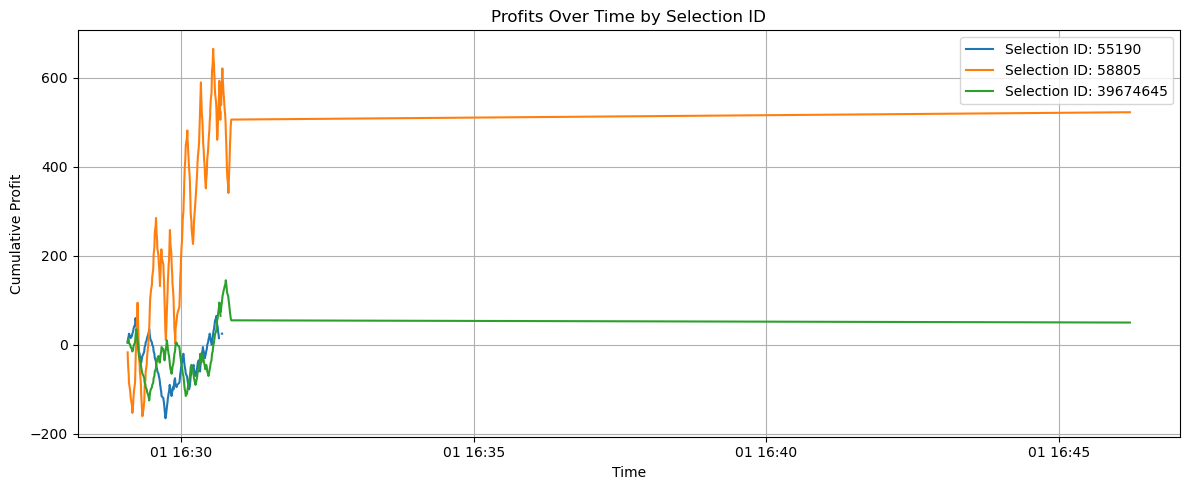

In [19]:
import matplotlib.pyplot as plt

# Convert the date_time_placed column to datetime format
df['date_time_placed'] = pd.to_datetime(df['date_time_placed'])

# Group by selection_id and date_time_placed and sum the profit
profit_over_time = df.groupby(['selection_id', 'date_time_placed'])['profit'].sum().unstack('selection_id').cumsum()

# Plotting
plt.figure(figsize=(12, 5))
for selection_id, profit in profit_over_time.iteritems():
    plt.plot(profit, label=f'Selection ID: {selection_id}')

plt.title('Profits Over Time by Selection ID')
plt.xlabel('Time')
plt.ylabel('Cumulative Profit')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
